<a href="https://colab.research.google.com/github/babymlin/vesel_segmentation/blob/main/vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

     |████████████████████████████████| 686kB 34.6MB/s 


#### Download data

In [2]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

Downloading...
From: https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
To: /content/vessel_seg.zip
29.2MB [00:00, 80.3MB/s]


In [3]:
# unzip file
!unzip -q vessel_seg.zip

#### Data Analysis

In [4]:
# read img and mask
img_paths = glob('all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

img path:  all/train/23_training.tif
mask path: all/train/23_manual1.gif


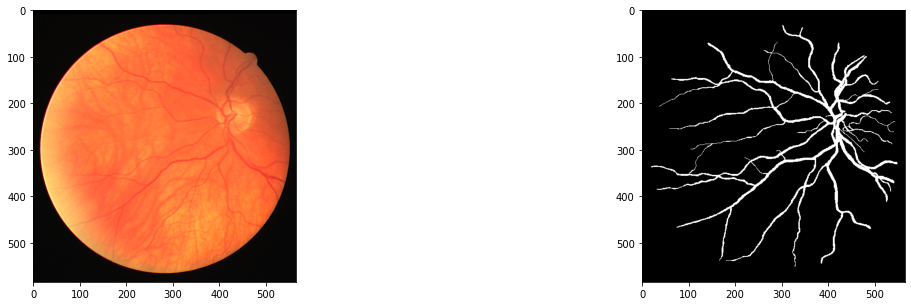

In [5]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

#### Data processing

In [7]:
IMG_SIZE = 512
BS = 4

In [8]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Affine(
                rotate=(90, -90), # random rotate -45 ~ +45 degree
                shear=(-3,3), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1)
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [9]:
all_paths = glob('all/train/*.tif')
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

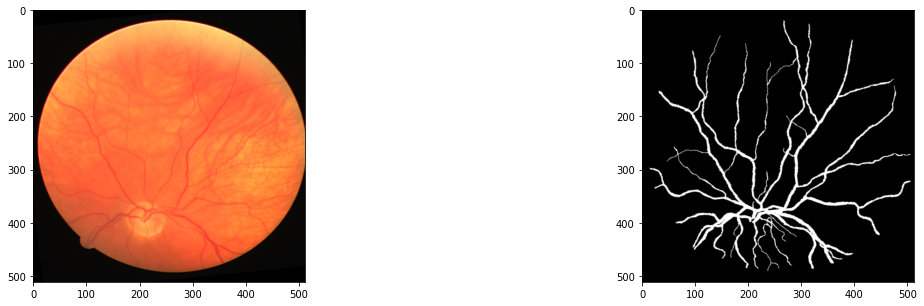

In [10]:
# Check output

batch_x, batch_y = train_gen[0]

batch_i = np.random.choice(len(batch_x))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i])
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray')
plt.show()

#### Build model

In [11]:
def conv_bn(x, filters):
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_bn(input_layer, 1)
x = conv_bn(x, 8)
c1 = conv_bn(x, 8)
x = layers.MaxPool2D(strides=(2,2))(c1)
x = conv_bn(x, 8)
x = conv_bn(x, 16)
c2 = conv_bn(x, 16)
x = layers.MaxPool2D(strides=(2,2))(c2)
x = conv_bn(x, 16)
x = conv_bn(x, 32)
c3 = conv_bn(x, 32)
x = layers.MaxPool2D(strides=(2,2))(c3)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
c4 = conv_bn(x, 64)

x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(c4),
              layers.Conv2DTranspose(64, 3, strides=2, padding='same')(c4),
              c3], axis=-1)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
              layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
              c2], axis=-1)
x = conv_bn(x, 16)
x = conv_bn(x, 16)
x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
              layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x),
              c1], axis=-1)
x = conv_bn(x, 8)
x = conv_bn(x, 8)

output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                         
model = models.Model(input_layer, output_layer)

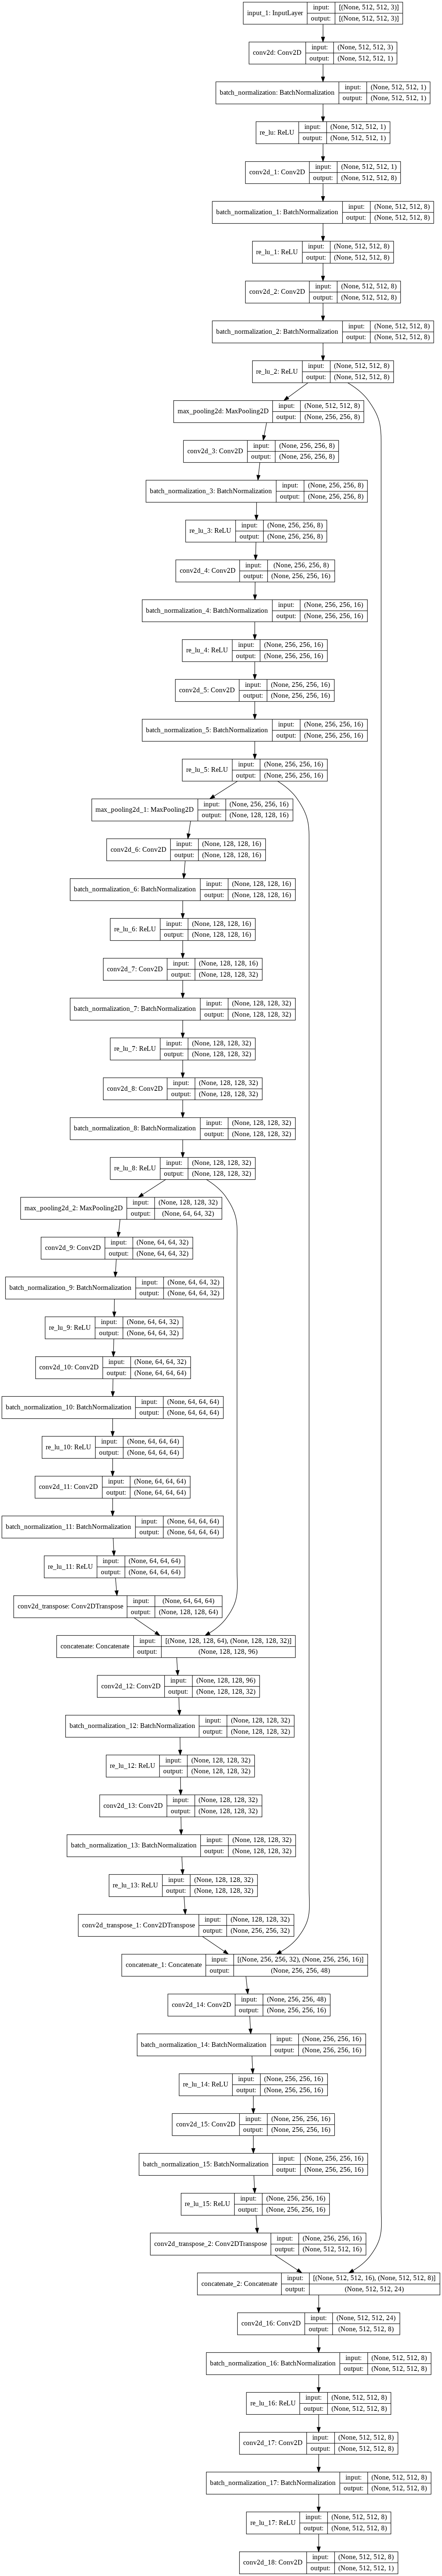

In [12]:
utils.plot_model(model, show_shapes=True)

#### Training

In [13]:
# Customize Dice coefficient
# K = tf.keras.backend
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true,)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f, )
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()) # 1e-6, 1e-7

def dice_lose(y_true, y_pred):
    y_true_f = K.flatten(y_true,)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f, )
    return 1 - ((2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())) # 1e-6, 1e-7

In [14]:
Radam = tfa.optimizers.RectifiedAdam(1e-4)
Ranger = tfa.optimizers.Lookahead(Radam)
model.compile(optimizer=Ranger, 
        loss='binary_crossentropy', 
        metrics=[dice_coef])

In [17]:
modelcp = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [ ]:
logs = model.fit(train_gen,
          validation_data = val_gen,
          epochs=1000,
          verbose=2,
          callbacks = [modelcp, earlystop])

Epoch 1/1000
4/4 - 1s - loss: 0.1043 - dice_coef: 0.6533 - val_loss: 0.0950 - val_dice_coef: 0.6716
Epoch 2/1000
4/4 - 1s - loss: 0.1048 - dice_coef: 0.6537 - val_loss: 0.0948 - val_dice_coef: 0.6733
Epoch 3/1000
4/4 - 1s - loss: 0.1014 - dice_coef: 0.6496 - val_loss: 0.0948 - val_dice_coef: 0.6750
Epoch 4/1000
4/4 - 1s - loss: 0.1029 - dice_coef: 0.6547 - val_loss: 0.0947 - val_dice_coef: 0.6753
Epoch 5/1000
4/4 - 1s - loss: 0.1039 - dice_coef: 0.6532 - val_loss: 0.0947 - val_dice_coef: 0.6755
Epoch 6/1000
4/4 - 1s - loss: 0.0985 - dice_coef: 0.6434 - val_loss: 0.0948 - val_dice_coef: 0.6778
Epoch 7/1000
4/4 - 1s - loss: 0.1086 - dice_coef: 0.6568 - val_loss: 0.0945 - val_dice_coef: 0.6763
Epoch 8/1000
4/4 - 1s - loss: 0.0987 - dice_coef: 0.6485 - val_loss: 0.0946 - val_dice_coef: 0.6756
Epoch 9/1000
4/4 - 1s - loss: 0.0964 - dice_coef: 0.6483 - val_loss: 0.0946 - val_dice_coef: 0.6761
Epoch 10/1000
4/4 - 1s - loss: 0.0990 - dice_coef: 0.6538 - val_loss: 0.0945 - val_dice_coef: 0.6757

#### Evaluate

In [ ]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [24]:
#model_final = models.load_model('seg.h5', compile=False)

0


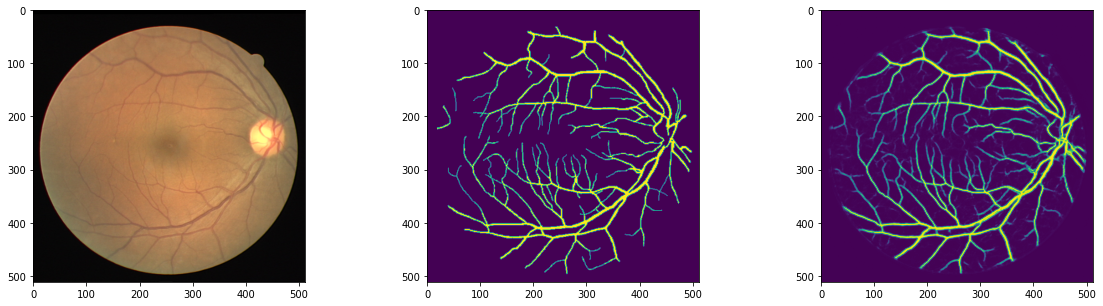

In [32]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
#mask_pred = model_final.predict(imgs)
mask_pred = model.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [34]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[0.00790371, 0.01026281, 0.00593547, ..., 0.01126873, 0.00972968,
        0.00838239],
       [0.00688737, 0.00890584, 0.00594361, ..., 0.00881074, 0.00862262,
        0.00786448],
       [0.00601163, 0.00795368, 0.00614041, ..., 0.00540301, 0.00680149,
        0.00685731],
       ...,
       [0.0052598 , 0.00563361, 0.005636  , ..., 0.00540373, 0.00492531,
        0.00665791],
       [0.00522993, 0.00544172, 0.00558398, ..., 0.00471642, 0.00464509,
        0.00592524],
       [0.0051771 , 0.00537551, 0.00564825, ..., 0.00513923, 0.00509653,
        0.00550231]], dtype=float32)

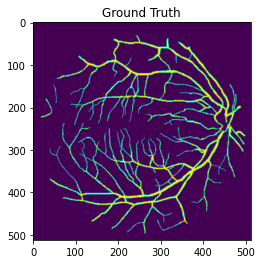

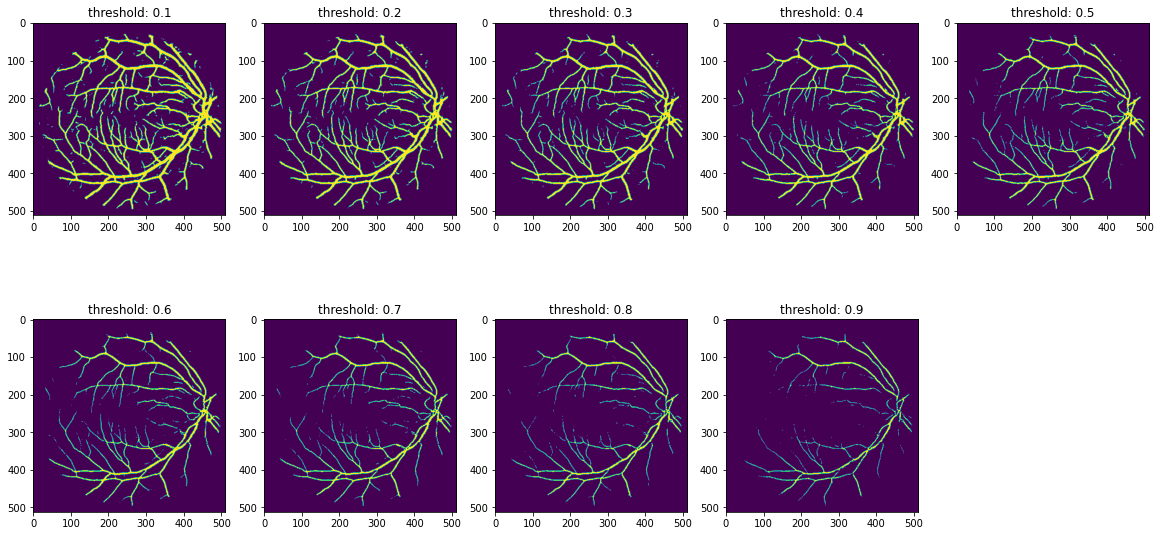

In [35]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

#### Make Kaggle prediction

https://www.kaggle.com/c/sai-vessel-segmentation/leaderboard

In [36]:
# make prediction
threshold = 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    #y_preds = model_final.predict(x_test)
    y_preds = model.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

In [37]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,16103 7 16615 6 16674 3 17128 2 17640 2 17671 ...
1,1,18696 3 18707 2 19209 4 19219 2 19722 4 19731 ...
2,2,12559 6 13068 12 13578 13 14089 9 14100 3 1411...
3,3,14072 3 14583 5 15092 8 15608 4 16121 5 16634 ...
4,4,16676 3 17154 1 17188 2 17664 3 17699 3 18174 ...
5,5,17150 5 17663 2 18212 1 18726 6 19146 6 19200 ...
6,6,17127 5 17168 2 17642 4 17680 2 18155 4 18193 ...
7,7,16617 4 16656 4 17128 6 17169 4 17642 5 17681 ...
8,8,15601 4 15607 6 15614 2 15636 5 16108 16 16147...
9,9,16639 3 17113 2 17149 6 17625 3 17663 4 18137 ...
